In [25]:
import numpy as np
import scanpy as sc
import pandas as pd
import anndata as ad
import scvi
import matplotlib.pyplot as plt
import torch

In [2]:
rosmap = sc.read_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/dlpfc2/raw_h5ad/all_hvg_rosmap_align.h5ad')
diverse_cohort = sc.read_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/diverse_cohort/diverse_cohort_hvg_rosmap_annot_align.h5ad')
multi_region = sc.read_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap_multiome/all_brain_regions_filt_preprocessed_scanpy_fullmatrix_annot_hvg_rosmap_annot_align.h5ad')
aging = sc.read_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap_aging/PFC427_raw_data_hvg_rosmap_annot_align.h5ad')


In [3]:
rosmap.X = rosmap.X.astype(np.float32)
diverse_cohort.X = diverse_cohort.X.astype(np.float32)

In [4]:
rosmap.X.dtype

dtype('float32')

In [5]:
diverse_cohort.X.dtype

dtype('float32')

In [6]:
multi_region.X.dtype

dtype('float32')

In [7]:
aging.X.dtype

dtype('float32')

In [8]:
adata = ad.concat([rosmap, diverse_cohort, multi_region, aging], join = 'outer')
adata.obs_names_make_unique()

/home/icb/zihe.zheng/miniconda3/envs/sysvi/lib/python3.12/site-packages/anndata/_core/merge.py:1434: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(
/home/icb/zihe.zheng/miniconda3/envs/sysvi/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [9]:
# subset
adata = adata[adata.obs.sample(frac=0.01, random_state=42).index].copy()

In [10]:
adata

AnnData object with n_obs × n_vars = 72534 × 2000
    obs: 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'batch', 'individualID', 'DoubletFinder.score', 'subset', 'class', 'state', 'projid', 'Study', 'msex', 'educ', 'race', 'spanish', 'apoe_genotype', 'age_at_visit_max', 'age_first_ad_dx', 'age_death', 'cts_mmse30_first_ad_dx', 'cts_mmse30_lv', 'pmi', 'braaksc', 'ceradsc', 'cogdx', 'dcfdx_lv', 'AD', 'aligned_cell_type', 'dataset_batch', 'nCount_RNA_x', 'nFeature_RNA_x', 'specimenID', 'region', 'barcode', 'nCount_RNA_y', 'nFeature_RNA_y', 'mt_percent', 'broadcellclass', 'subcellclass', 'cogdx_rush', 'braak_rush', 'cerad_rush', 'sex_x', 'allen_m1_azimuth_subclass', 'allen_m1_azimuth_subclass.score', 'allen_m1_azimuth_mapping.score', 'dataContributionGroup', 'cohort', 'sex_y', 'isHispanic', 'ageDeath', 'PMI', 'apoeGenotype', 'amyThal', 'amyA', 'amyCerad', 'Braak', 'mayoDx', 'amyAny', 'bScore', 'reag', 'ADoutcome', 'derivedOutcomeBasedOnMayoDx', 'clinicalMetadataSource', 'mid

In [11]:
scvi.model.SCVI.setup_anndata(adata, batch_key="dataset_batch")

model = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb")

model.train(max_epochs=2)

/home/icb/zihe.zheng/miniconda3/envs/sysvi/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/icb/zihe.zheng/miniconda3/envs/sysvi/lib/python3.12/site-packages/scvi/dataloaders/_data_splitting.py:258: UserWarning: 1 cells moved from training set to validation set. if you want to avoid it please use train_size parameter during train.
  self.n_train, self.n_val = validate_data_split(
/home/icb/zihe.zheng/miniconda3/envs/sysvi/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/zihe.zheng/miniconda3/envs/sysvi/lib/pytho ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using

Epoch 2/2: 100%|█████████████████| 2/2 [00:28<00:00, 12.89s/it, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.07e+3]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 2/2: 100%|█████████████████| 2/2 [00:28<00:00, 14.14s/it, v_num=1, train_loss_step=1.12e+3, train_loss_epoch=1.07e+3]


In [12]:
SCVI_LATENT_KEY = "X_scVI"
adata.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()

adata.obs = adata.obs.astype(str)

sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)
sc.tl.umap(adata)

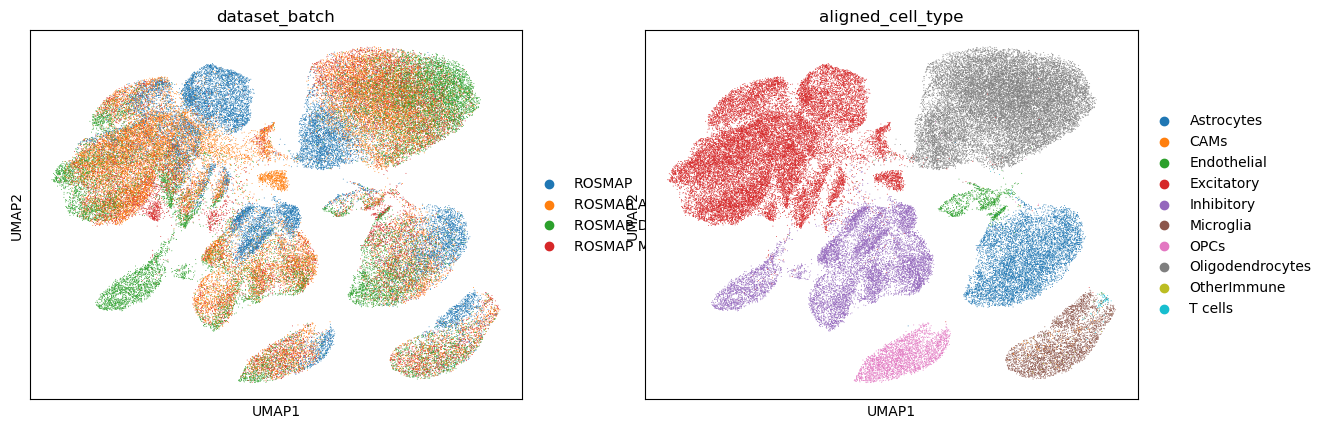

In [13]:
sc.pl.umap(adata, color = ['dataset_batch', 'aligned_cell_type'], show = True, save='_rosmap_all.pdf')

In [ ]:
adata.write_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/integrated_data/rosmap_everything_integrated.h5ad')

In [14]:
print(model.history.keys())

dict_keys(['kl_weight', 'train_loss_step', 'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 'kl_local_train', 'kl_global_train'])


In [17]:
SCVI_LATENT_KEY = "X_scVI"
adata.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()

adata.obs = adata.obs.astype(str)

sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)
sc.tl.umap(adata)

# sc.pl.umap(adata, color = ['dataset_batch', 'aligned_cell_type'], show = True, save='_rosmap_all.pdf')

adata.write_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/integrated_data/rosmap_everything_integrated.h5ad')


dict_keys(['kl_weight', 'train_loss_step', 'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 'kl_local_train', 'kl_global_train'])


In [19]:
# Access training history
history = model.history

# Optional: convert to DataFrame for easier handling
# history_df = pd.DataFrame(history)

In [22]:
history

{'kl_weight':       kl_weight
 epoch          
 0           0.0
 1        0.0025,
 'train_loss_step':       train_loss_step
 epoch                
 0         1163.468506
 1         1119.980225,
 'train_loss_epoch':       train_loss_epoch
 epoch                 
 0           1125.70459
 1          1068.558228,
 'elbo_train':         elbo_train
 epoch             
 0      1184.654907
 1      1161.176636,
 'reconstruction_loss_train':       reconstruction_loss_train
 epoch                          
 0                    1125.70459
 1                   1068.325684,
 'kl_local_train':       kl_local_train
 epoch               
 0           58.95026
 1          92.850983,
 'kl_global_train':       kl_global_train
 epoch                
 0                 0.0
 1                 0.0}

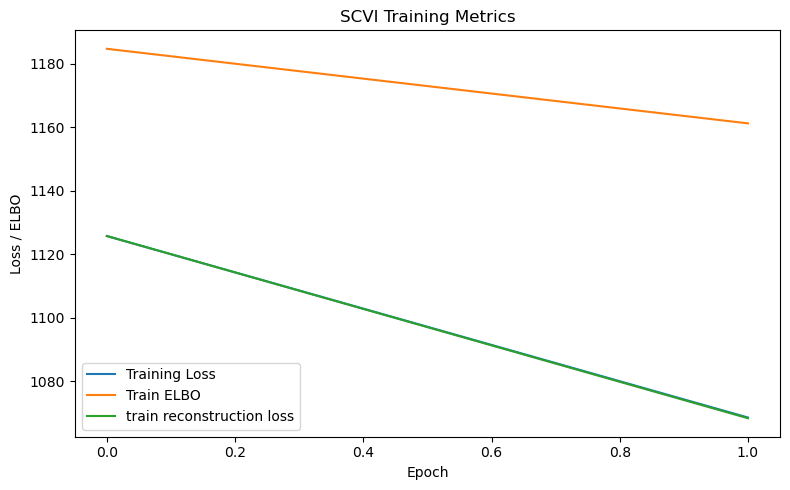

In [31]:
# Plot
plt.figure(figsize=(8, 5))

# Plot available metrics if they exist
if 'train_loss_epoch' in history:
    plt.plot(history['train_loss_epoch'], label='Training Loss')
if 'elbo_train' in history:
    plt.plot(history['elbo_train'], label='Train ELBO')
if 'reconstruction_loss_train' in history:
    plt.plot(history['reconstruction_loss_train'], label='train reconstruction loss')
if 'elbo_validation' in history:
    plt.plot(history['elbo_validation'], label='Validation ELBO')
if 'reconstruction_loss_validation' in history:
    plt.plot(history['reconstruction_loss_validation'], label='validation reconstruction loss')


plt.xlabel('Epoch')
plt.ylabel('Loss / ELBO')
plt.title('SCVI Training Metrics')
plt.legend()
plt.tight_layout()

# Save figure
plt.savefig('/home/icb/zihe.zheng/projects/microglia/plots/scvi_rosmap_losses.pdf', dpi=300)